In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter
from metrics import NNSE,ZNRMSE,PPTS,LPTS
from ConvertChineseToPinyin import convert_to_pinyin_capitalized

# Set default font size to 9 and default linewidth to 1
plt.rcParams.update({'font.size': 8, 'lines.linewidth': 1})
hydro_stations = [
    'Tangnaihai', 
    'Guide', 
    'Xunhua']
hydrostation_abbrs = {'Tangnaihai':'TNH','Guide':'GD','Xunhua':'XH'}
hydrostation_channel = {'Tangnaihai':'3','Guide':'14','Xunhua':'9'}
# read observed climate data
hydrostation_metestations = {
    'Tangnaihai': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
    ],
    'Guide': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德',
    ],
    'Xunhua': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德', '同仁',
    ]
}
metestation_controal_area = pd.read_csv('../data/MeteGaugeStationControlArea.csv')
metestation_controal_area_dict = dict(zip(metestation_controal_area['station'], metestation_controal_area['Shape_Area']))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


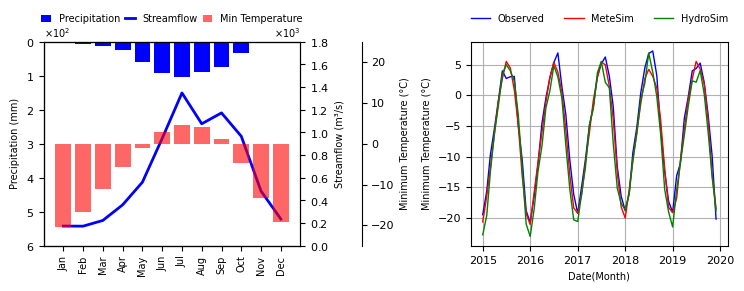

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


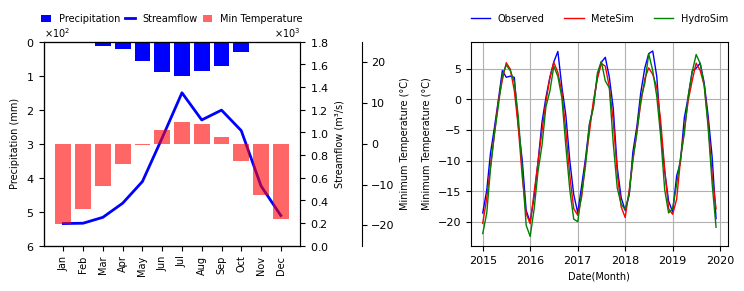

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


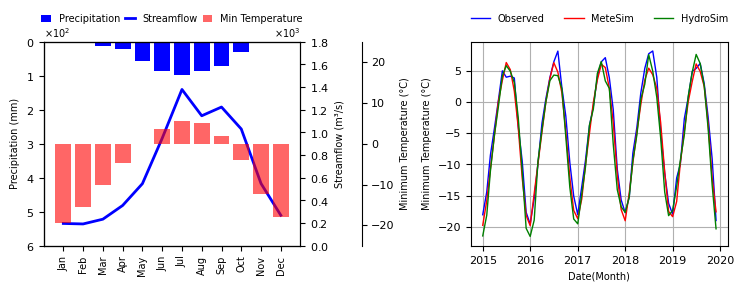

In [106]:
start = '1972-01-01'
end = '2019-12-31'
station_obs_mintemp = {}
station_obs_maxtemp = {}
station_metesim_mintemp = {}
station_metesim_maxtemp = {}
station_hydrosim_mintemp = {}
station_hydrosim_maxtemp = {}
pred_years = np.arange(2015,2020)
start_year = 1972
for hydro_station in hydro_stations:
    index = pd.date_range(f'{pred_years[0]}-01-01',f'{pred_years[-1]}-12-31',freq='MS')
    obs_mintmp_df = pd.DataFrame(index=index)
    obs_maxtmp_df = pd.DataFrame(index=index)
    metesim_mintmp_df = pd.DataFrame(index=index)
    metesim_maxtmp_df = pd.DataFrame(index=index)
    hydrosim_mintmp_df = pd.DataFrame(index=index)
    hydrosim_maxtmp_df = pd.DataFrame(index=index)
    
    station_names = hydrostation_metestations[hydro_station]
    index = pd.date_range(start,end,freq='MS')
    # Initialize DataFrames to store aggregated data
    pcp_data = pd.DataFrame()
    maxtmp_data = pd.DataFrame()
    mintmp_data = pd.DataFrame()
    slr_data = pd.DataFrame()
    hmd_data = pd.DataFrame()
    wnd_data = pd.DataFrame()
    total_area = sum(metestation_controal_area_dict[station] for station in station_names)
    weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}
    for station in station_names:
        # Read climate data for each station
        station_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station}.csv', 
                                   index_col=['DATE'], parse_dates=['DATE'])
        station_calval = station_data.loc[start:end]
        # Aggregate data
        pcp_data[station] = station_calval['P2020(mm)'].resample('MS').sum() * weights[station]
        maxtmp_data[station] = station_calval['MAX-TEM(C)'].resample('MS').mean() * weights[station]
        mintmp_data[station] = station_calval['MIN-TEM(C)'].resample('MS').mean() * weights[station]
        slr_data[station] = station_calval['SLR(MJ/m^2)'].resample('MS').sum() * weights[station]
        hmd_data[station] = station_calval['AVG-RHU(%)'].resample('MS').mean() * weights[station]
        wnd_data[station] = station_calval['AVG-WV(m/s)'].resample('MS').mean() * weights[station]

    # Calculate weighted averages across stations
    pcp_avg = pcp_data.sum(axis=1)
    pcp_avg.name = 'P2020(mm)'
    pcp_avg.index = index
    maxtmp_avg = maxtmp_data.sum(axis=1)
    maxtmp_avg.name = 'MAX-TEM(C)'
    maxtmp_avg.index = index
    mintmp_avg = mintmp_data.sum(axis=1)
    mintmp_avg.name = 'MIN-TEM(C)'
    mintmp_avg.index = index
    slr_avg = slr_data.sum(axis=1)
    slr_avg.name = 'SLR(MJ/m^2)'
    slr_avg.index = index
    hmd_avg = hmd_data.sum(axis=1)
    hmd_avg.name = 'AVG-RHU(%)'
    hmd_avg.index = index
    wnd_avg = wnd_data.sum(axis=1)
    wnd_avg.name = 'AVG-WV(m/s)'
    wnd_avg.index = index

    # Read water balance data
    wb = pd.read_csv(f'../result/SWATPlusCalValSimData/YellowRiver{hydrostation_abbrs[hydro_station]}_BasinWaterBalance_1972_2019.csv', 
                     index_col=['date'], parse_dates=['date'])
    wb = wb.loc[start:end]
    wb = wb.drop(columns=['mon', 'day', 'yr', 'name'])
    wb = wb.sort_index()
    wb.index = index

    # Read monthly streamflow data
    flow = pd.read_csv(f'../data/{hydro_station}_natural_monthly_flow.csv', 
                       index_col=['date'], parse_dates=['date'])
    flow = flow.loc[start:end]
    flow = flow.sort_index()
    flow.index = index

    # Calculate mean monthly precipitation, streamflow, maximum temperature
    monthly_pcp = pcp_avg.groupby(pcp_avg.index.month).mean()
    monthly_flow = flow.groupby(flow.index.month).mean()
    monthly_mintemp = mintmp_avg.groupby(mintmp_avg.index.month).mean()
    monthly_wb_pcp = wb['precip(mm)'].groupby(wb.index.month).mean()

    obs_mintmp = mintmp_avg.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
    obs_maxtmp = maxtmp_avg.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
    station_obs_mintemp[hydro_station] = obs_mintmp
    station_obs_maxtemp[hydro_station] = obs_maxtmp

    # MeteSim
    similarity_years = pd.read_csv(f'../result/SimilarityYears/SimilarityYears_{hydro_station}.csv', index_col=['tar_year'])
    station_names = hydrostation_metestations[hydro_station]
    for pred_year in pred_years:
        pred_index = pd.date_range(f'{start_year}-01-01', f'{pred_year}-12-31', freq='MS')
        # Initialize DataFrames to store aggregated data
        pcp_data = pd.DataFrame(index=pred_index)
        maxtmp_data = pd.DataFrame(index=pred_index)
        mintmp_data = pd.DataFrame(index=pred_index)
        slr_data = pd.DataFrame(index=pred_index)
        hmd_data = pd.DataFrame(index=pred_index)
        wnd_data = pd.DataFrame(index=pred_index)

        total_area = sum(metestation_controal_area_dict[station] for station in station_names)
        weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}

        for station_name in station_names:
            climate_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station_name}.csv', 
                                       index_col=['DATE'], parse_dates=['DATE'])
            
            tar_year = pred_year #将预测年份数据进行替换
            ref_year = similarity_years.loc[tar_year-1, station_name] + 1
            
            target_data = climate_data[climate_data.index.year == tar_year]
            reference_data = climate_data[climate_data.index.year == ref_year]
            
            if len(reference_data) == len(target_data):
                climate_data.loc[target_data.index, :] = reference_data.values
            elif len(reference_data) > len(target_data):
                reference_data = reference_data[:-1]
                climate_data.loc[target_data.index, :] = reference_data.values
            else:
                last_day = reference_data.iloc[-1:]
                reference_data = pd.concat([reference_data, last_day])
                climate_data.loc[target_data.index, :] = reference_data.values

            climate_data = climate_data.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
            
            pcp_data[station_name] = climate_data['P2020(mm)'].resample('MS').sum() * weights[station_name]
            maxtmp_data[station_name] = climate_data['MAX-TEM(C)'].resample('MS').mean() * weights[station_name]
            mintmp_data[station_name] = climate_data['MIN-TEM(C)'].resample('MS').mean() * weights[station_name]
            slr_data[station_name] = climate_data['SLR(MJ/m^2)'].resample('MS').sum() * weights[station_name]
            hmd_data[station_name] = climate_data['AVG-RHU(%)'].resample('MS').mean() * weights[station_name]
            wnd_data[station_name] = climate_data['AVG-WV(m/s)'].resample('MS').mean() * weights[station_name]

        # Calculate weighted averages across stations
        pcp_avg = pcp_data.sum(axis=1)
        pcp_avg.name = 'P2020(mm)'
        pcp_avg = pcp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        pcp_avg = pcp_avg.sort_index()
        pcp_avg.index = pred_index

        maxtmp_avg = maxtmp_data.sum(axis=1)
        maxtmp_avg.name = 'MAX-TEM(C)'
        maxtmp_avg = maxtmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        maxtmp_avg = maxtmp_avg.sort_index()
        maxtmp_avg.index = pred_index

        mintmp_avg = mintmp_data.sum(axis=1)
        mintmp_avg.name = 'MIN-TEM(C)'
        mintmp_avg = mintmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        mintmp_avg = mintmp_avg.sort_index()
        mintmp_avg.index = pred_index

        slr_avg = slr_data.sum(axis=1)
        slr_avg.name = 'SLR(MJ/m^2)'
        slr_avg = slr_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        slr_avg = slr_avg.sort_index()
        slr_avg.index = pred_index

        hmd_avg = hmd_data.sum(axis=1)
        hmd_avg.name = 'AVG-RHU(%)'
        hmd_avg = hmd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        hmd_avg = hmd_avg.sort_index()
        hmd_avg.index = pred_index

        wnd_avg = wnd_data.sum(axis=1)
        wnd_avg.name = 'AVG-WV(m/s)'
        wnd_avg = wnd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        wnd_avg = wnd_avg.sort_index()
        wnd_avg.index = pred_index
    
        metesim_mintmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = mintmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
        metesim_maxtmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = maxtmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
    station_metesim_mintemp[hydro_station] = metesim_mintmp
    station_metesim_maxtemp[hydro_station] = metesim_maxtmp
    

    # HydroSim
    similarity_years = pd.read_csv(f'../result/SimilarityYears/{hydro_station}_hydrological_similiarity_year.csv')
    similarity_dict = dict(zip(similarity_years['PredYear'], similarity_years['SimYear']))
    station_names = hydrostation_metestations[hydro_station]
    
    for pred_year in pred_years:

        pred_index = pd.date_range(f'{start_year}-01-01', f'{pred_year}-12-31', freq='MS')

        # Initialize DataFrames to store aggregated data
        pcp_data = pd.DataFrame(index=pred_index)
        maxtmp_data = pd.DataFrame(index=pred_index)
        mintmp_data = pd.DataFrame(index=pred_index)
        slr_data = pd.DataFrame(index=pred_index)
        hmd_data = pd.DataFrame(index=pred_index)
        wnd_data = pd.DataFrame(index=pred_index)

        total_area = sum(metestation_controal_area_dict[station] for station in station_names)
        weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}

        for station_name in station_names:
            climate_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station_name}.csv', 
                                       index_col=['DATE'], parse_dates=['DATE'])
            
            tar_year = pred_year #将预测年份数据进行替换
            ref_year = similarity_dict[pred_year]
            
            target_data = climate_data[climate_data.index.year == tar_year]
            reference_data = climate_data[climate_data.index.year == ref_year]
            
            if len(reference_data) == len(target_data):
                climate_data.loc[target_data.index, :] = reference_data.values
            elif len(reference_data) > len(target_data):
                reference_data = reference_data[:-1]
                climate_data.loc[target_data.index, :] = reference_data.values
            else:
                last_day = reference_data.iloc[-1:]
                reference_data = pd.concat([reference_data, last_day])
                climate_data.loc[target_data.index, :] = reference_data.values

            climate_data = climate_data.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
            
            pcp_data[station_name] = climate_data['P2020(mm)'].resample('MS').sum() * weights[station_name]
            maxtmp_data[station_name] = climate_data['MAX-TEM(C)'].resample('MS').mean() * weights[station_name]
            mintmp_data[station_name] = climate_data['MIN-TEM(C)'].resample('MS').mean() * weights[station_name]
            slr_data[station_name] = climate_data['SLR(MJ/m^2)'].resample('MS').sum() * weights[station_name]
            hmd_data[station_name] = climate_data['AVG-RHU(%)'].resample('MS').mean() * weights[station_name]
            wnd_data[station_name] = climate_data['AVG-WV(m/s)'].resample('MS').mean() * weights[station_name]

        # Calculate weighted averages across stations
        pcp_avg = pcp_data.sum(axis=1)
        pcp_avg.name = 'P2020(mm)'
        pcp_avg = pcp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        pcp_avg = pcp_avg.sort_index()
        pcp_avg.index = pred_index

        maxtmp_avg = maxtmp_data.sum(axis=1)
        maxtmp_avg.name = 'MAX-TEM(C)'
        maxtmp_avg = maxtmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        maxtmp_avg = maxtmp_avg.sort_index()
        maxtmp_avg.index = pred_index

        mintmp_avg = mintmp_data.sum(axis=1)
        mintmp_avg.name = 'MIN-TEM(C)'
        mintmp_avg = mintmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        mintmp_avg = mintmp_avg.sort_index()
        mintmp_avg.index = pred_index

        slr_avg = slr_data.sum(axis=1)
        slr_avg.name = 'SLR(MJ/m^2)'
        slr_avg = slr_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        slr_avg = slr_avg.sort_index()
        slr_avg.index = pred_index

        hmd_avg = hmd_data.sum(axis=1)
        hmd_avg.name = 'AVG-RHU(%)'
        hmd_avg = hmd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        hmd_avg = hmd_avg.sort_index()
        hmd_avg.index = pred_index

        wnd_avg = wnd_data.sum(axis=1)
        wnd_avg.name = 'AVG-WV(m/s)'
        wnd_avg = wnd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        wnd_avg = wnd_avg.sort_index()
        wnd_avg.index = pred_index

        hydrosim_mintmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = mintmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
        hydrosim_maxtmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = maxtmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
    station_hydrosim_mintemp[hydro_station] = hydrosim_mintmp
    station_hydrosim_maxtemp[hydro_station] = hydrosim_maxtmp

    # Create figure with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.48, 3.00))
    
    # First subplot (left)
    ax1_twin = ax1.twinx()
    ax1_twin2 = ax1.twinx()
    
    # Offset the right spine of ax1_twin2 for clarity
    ax1_twin2.spines['right'].set_position(('outward', 44))

    # Plot precipitation as inverted bars
    precip_bars = ax1.bar(range(1,13), monthly_pcp.values, color='blue', alpha=1.0, label='Precipitation')
    ax1.set_ylim(600, 0)  # Invert y-axis with increased range
    ax1.set_ylabel('Precipitation (mm)', fontsize=fontsize)
    # Set scientific notation for precipitation axis with font size 8
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.yaxis.get_offset_text().set_fontsize(fontsize)

    # Plot streamflow as line
    flow_line = ax1_twin.plot(range(1,13), monthly_flow.values, color='blue', linewidth=2, label='Streamflow')[0]
    ax1_twin.set_ylabel('Streamflow (m³/s)', fontsize=fontsize)
    ax1_twin.set_ylim(0,1800)
    # Set scientific notation for streamflow axis with font size 8
    ax1_twin.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1_twin.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1_twin.yaxis.get_offset_text().set_fontsize(fontsize)

    # Plot minimum temperature as bars
    temp_bars = ax1_twin2.bar(range(1,13), monthly_mintemp.values, color='red', alpha=0.6, label='Min Temperature')
    ax1_twin2.set_ylabel('Minimum Temperature (°C)', fontsize=fontsize)
    ax1_twin2.set_ylim(-25,25)

    # Add legend at top with 3 columns
    ax1.legend([precip_bars, flow_line, temp_bars], 
               ['Precipitation', 'Streamflow', 'Min Temperature'],
               loc='upper center', bbox_to_anchor=(0.5, 1.18),
               ncol=3, fontsize=fontsize, frameon=False,handlelength=1,columnspacing=0.4)

    # Set x-axis labels with 90 degree rotation
    ax1.set_xticks(range(1,13))
    ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                        fontsize=fontsize, rotation=90)

    # Second subplot (right)
    dates = station_obs_mintemp[hydro_station].index
    ax2.plot(dates, station_obs_mintemp[hydro_station], 'b-', label='Observed')
    ax2.plot(dates, station_metesim_mintemp[hydro_station], 'r-', label='MeteSim')
    ax2.plot(dates, station_hydrosim_mintemp[hydro_station], 'g-', label='HydroSim')
    ax2.set_xlabel('Date(Month)', fontsize=fontsize)
    ax2.set_ylabel('Minimum Temperature (°C)', fontsize=fontsize)
    # Move legend to top with 3 columns
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), 
              ncol=3, fontsize=fontsize, frameon=False)
    ax2.grid(True)

    # plt.subplots_adjust(left=0.12,right=0.99,bottom=0.15,top=0.90,wspace=0.6)
    plt.tight_layout()
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}.png',format='png',dpi=300)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}.eps',format='eps',dpi=1000)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}.tif', format='TIFF', dpi=500)
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


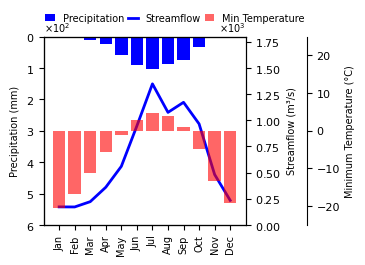

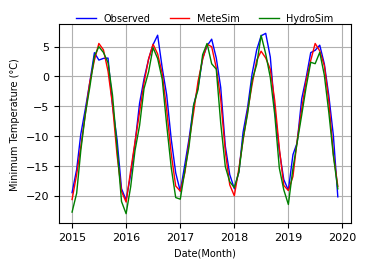

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


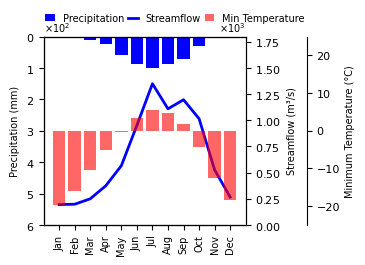

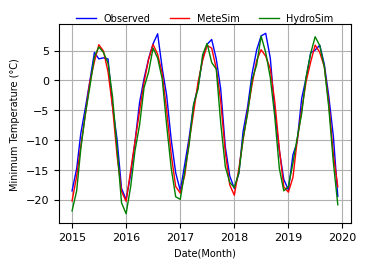

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


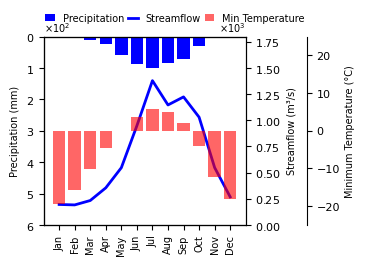

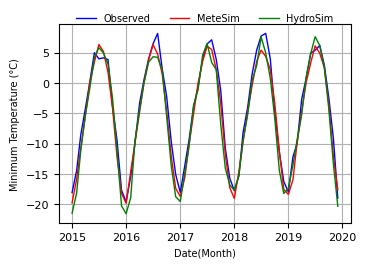

In [119]:
start = '1972-01-01'
end = '2019-12-31'
station_obs_mintemp = {}
station_obs_maxtemp = {}
station_metesim_mintemp = {}
station_metesim_maxtemp = {}
station_hydrosim_mintemp = {}
station_hydrosim_maxtemp = {}
pred_years = np.arange(2015,2020)
start_year = 1972
for hydro_station in hydro_stations:
    index = pd.date_range(f'{pred_years[0]}-01-01',f'{pred_years[-1]}-12-31',freq='MS')
    obs_mintmp_df = pd.DataFrame(index=index)
    obs_maxtmp_df = pd.DataFrame(index=index)
    metesim_mintmp_df = pd.DataFrame(index=index)
    metesim_maxtmp_df = pd.DataFrame(index=index)
    hydrosim_mintmp_df = pd.DataFrame(index=index)
    hydrosim_maxtmp_df = pd.DataFrame(index=index)
    
    station_names = hydrostation_metestations[hydro_station]
    index = pd.date_range(start,end,freq='MS')
    # Initialize DataFrames to store aggregated data
    pcp_data = pd.DataFrame()
    maxtmp_data = pd.DataFrame()
    mintmp_data = pd.DataFrame()
    slr_data = pd.DataFrame()
    hmd_data = pd.DataFrame()
    wnd_data = pd.DataFrame()
    total_area = sum(metestation_controal_area_dict[station] for station in station_names)
    weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}
    for station in station_names:
        # Read climate data for each station
        station_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station}.csv', 
                                   index_col=['DATE'], parse_dates=['DATE'])
        station_calval = station_data.loc[start:end]
        # Aggregate data
        pcp_data[station] = station_calval['P2020(mm)'].resample('MS').sum() * weights[station]
        maxtmp_data[station] = station_calval['MAX-TEM(C)'].resample('MS').mean() * weights[station]
        mintmp_data[station] = station_calval['MIN-TEM(C)'].resample('MS').mean() * weights[station]
        slr_data[station] = station_calval['SLR(MJ/m^2)'].resample('MS').sum() * weights[station]
        hmd_data[station] = station_calval['AVG-RHU(%)'].resample('MS').mean() * weights[station]
        wnd_data[station] = station_calval['AVG-WV(m/s)'].resample('MS').mean() * weights[station]

    # Calculate weighted averages across stations
    pcp_avg = pcp_data.sum(axis=1)
    pcp_avg.name = 'P2020(mm)'
    pcp_avg.index = index
    maxtmp_avg = maxtmp_data.sum(axis=1)
    maxtmp_avg.name = 'MAX-TEM(C)'
    maxtmp_avg.index = index
    mintmp_avg = mintmp_data.sum(axis=1)
    mintmp_avg.name = 'MIN-TEM(C)'
    mintmp_avg.index = index
    slr_avg = slr_data.sum(axis=1)
    slr_avg.name = 'SLR(MJ/m^2)'
    slr_avg.index = index
    hmd_avg = hmd_data.sum(axis=1)
    hmd_avg.name = 'AVG-RHU(%)'
    hmd_avg.index = index
    wnd_avg = wnd_data.sum(axis=1)
    wnd_avg.name = 'AVG-WV(m/s)'
    wnd_avg.index = index

    # Read water balance data
    wb = pd.read_csv(f'../result/SWATPlusCalValSimData/YellowRiver{hydrostation_abbrs[hydro_station]}_BasinWaterBalance_1972_2019.csv', 
                     index_col=['date'], parse_dates=['date'])
    wb = wb.loc[start:end]
    wb = wb.drop(columns=['mon', 'day', 'yr', 'name'])
    wb = wb.sort_index()
    wb.index = index

    # Read monthly streamflow data
    flow = pd.read_csv(f'../data/{hydro_station}_natural_monthly_flow.csv', 
                       index_col=['date'], parse_dates=['date'])
    flow = flow.loc[start:end]
    flow = flow.sort_index()
    flow.index = index

    # Calculate mean monthly precipitation, streamflow, maximum temperature
    monthly_pcp = pcp_avg.groupby(pcp_avg.index.month).mean()
    monthly_flow = flow.groupby(flow.index.month).mean()
    monthly_mintemp = mintmp_avg.groupby(mintmp_avg.index.month).mean()
    monthly_wb_pcp = wb['precip(mm)'].groupby(wb.index.month).mean()

    obs_mintmp = mintmp_avg.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
    obs_maxtmp = maxtmp_avg.loc[f'{pred_years[0]}-01-01':f'{pred_years[-1]}-12-31']
    station_obs_mintemp[hydro_station] = obs_mintmp
    station_obs_maxtemp[hydro_station] = obs_maxtmp

    # MeteSim
    similarity_years = pd.read_csv(f'../result/SimilarityYears/SimilarityYears_{hydro_station}.csv', index_col=['tar_year'])
    station_names = hydrostation_metestations[hydro_station]
    for pred_year in pred_years:
        pred_index = pd.date_range(f'{start_year}-01-01', f'{pred_year}-12-31', freq='MS')
        # Initialize DataFrames to store aggregated data
        pcp_data = pd.DataFrame(index=pred_index)
        maxtmp_data = pd.DataFrame(index=pred_index)
        mintmp_data = pd.DataFrame(index=pred_index)
        slr_data = pd.DataFrame(index=pred_index)
        hmd_data = pd.DataFrame(index=pred_index)
        wnd_data = pd.DataFrame(index=pred_index)

        total_area = sum(metestation_controal_area_dict[station] for station in station_names)
        weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}

        for station_name in station_names:
            climate_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station_name}.csv', 
                                       index_col=['DATE'], parse_dates=['DATE'])
            
            tar_year = pred_year #将预测年份数据进行替换
            ref_year = similarity_years.loc[tar_year-1, station_name] + 1
            
            target_data = climate_data[climate_data.index.year == tar_year]
            reference_data = climate_data[climate_data.index.year == ref_year]
            
            if len(reference_data) == len(target_data):
                climate_data.loc[target_data.index, :] = reference_data.values
            elif len(reference_data) > len(target_data):
                reference_data = reference_data[:-1]
                climate_data.loc[target_data.index, :] = reference_data.values
            else:
                last_day = reference_data.iloc[-1:]
                reference_data = pd.concat([reference_data, last_day])
                climate_data.loc[target_data.index, :] = reference_data.values

            climate_data = climate_data.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
            
            pcp_data[station_name] = climate_data['P2020(mm)'].resample('MS').sum() * weights[station_name]
            maxtmp_data[station_name] = climate_data['MAX-TEM(C)'].resample('MS').mean() * weights[station_name]
            mintmp_data[station_name] = climate_data['MIN-TEM(C)'].resample('MS').mean() * weights[station_name]
            slr_data[station_name] = climate_data['SLR(MJ/m^2)'].resample('MS').sum() * weights[station_name]
            hmd_data[station_name] = climate_data['AVG-RHU(%)'].resample('MS').mean() * weights[station_name]
            wnd_data[station_name] = climate_data['AVG-WV(m/s)'].resample('MS').mean() * weights[station_name]

        # Calculate weighted averages across stations
        pcp_avg = pcp_data.sum(axis=1)
        pcp_avg.name = 'P2020(mm)'
        pcp_avg = pcp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        pcp_avg = pcp_avg.sort_index()
        pcp_avg.index = pred_index

        maxtmp_avg = maxtmp_data.sum(axis=1)
        maxtmp_avg.name = 'MAX-TEM(C)'
        maxtmp_avg = maxtmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        maxtmp_avg = maxtmp_avg.sort_index()
        maxtmp_avg.index = pred_index

        mintmp_avg = mintmp_data.sum(axis=1)
        mintmp_avg.name = 'MIN-TEM(C)'
        mintmp_avg = mintmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        mintmp_avg = mintmp_avg.sort_index()
        mintmp_avg.index = pred_index

        slr_avg = slr_data.sum(axis=1)
        slr_avg.name = 'SLR(MJ/m^2)'
        slr_avg = slr_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        slr_avg = slr_avg.sort_index()
        slr_avg.index = pred_index

        hmd_avg = hmd_data.sum(axis=1)
        hmd_avg.name = 'AVG-RHU(%)'
        hmd_avg = hmd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        hmd_avg = hmd_avg.sort_index()
        hmd_avg.index = pred_index

        wnd_avg = wnd_data.sum(axis=1)
        wnd_avg.name = 'AVG-WV(m/s)'
        wnd_avg = wnd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        wnd_avg = wnd_avg.sort_index()
        wnd_avg.index = pred_index
    
        metesim_mintmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = mintmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
        metesim_maxtmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = maxtmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
    station_metesim_mintemp[hydro_station] = metesim_mintmp
    station_metesim_maxtemp[hydro_station] = metesim_maxtmp
    

    # HydroSim
    similarity_years = pd.read_csv(f'../result/SimilarityYears/{hydro_station}_hydrological_similiarity_year.csv')
    similarity_dict = dict(zip(similarity_years['PredYear'], similarity_years['SimYear']))
    station_names = hydrostation_metestations[hydro_station]
    
    for pred_year in pred_years:

        pred_index = pd.date_range(f'{start_year}-01-01', f'{pred_year}-12-31', freq='MS')

        # Initialize DataFrames to store aggregated data
        pcp_data = pd.DataFrame(index=pred_index)
        maxtmp_data = pd.DataFrame(index=pred_index)
        mintmp_data = pd.DataFrame(index=pred_index)
        slr_data = pd.DataFrame(index=pred_index)
        hmd_data = pd.DataFrame(index=pred_index)
        wnd_data = pd.DataFrame(index=pred_index)

        total_area = sum(metestation_controal_area_dict[station] for station in station_names)
        weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}

        for station_name in station_names:
            climate_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station_name}.csv', 
                                       index_col=['DATE'], parse_dates=['DATE'])
            
            tar_year = pred_year #将预测年份数据进行替换
            ref_year = similarity_dict[pred_year]
            
            target_data = climate_data[climate_data.index.year == tar_year]
            reference_data = climate_data[climate_data.index.year == ref_year]
            
            if len(reference_data) == len(target_data):
                climate_data.loc[target_data.index, :] = reference_data.values
            elif len(reference_data) > len(target_data):
                reference_data = reference_data[:-1]
                climate_data.loc[target_data.index, :] = reference_data.values
            else:
                last_day = reference_data.iloc[-1:]
                reference_data = pd.concat([reference_data, last_day])
                climate_data.loc[target_data.index, :] = reference_data.values

            climate_data = climate_data.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
            
            pcp_data[station_name] = climate_data['P2020(mm)'].resample('MS').sum() * weights[station_name]
            maxtmp_data[station_name] = climate_data['MAX-TEM(C)'].resample('MS').mean() * weights[station_name]
            mintmp_data[station_name] = climate_data['MIN-TEM(C)'].resample('MS').mean() * weights[station_name]
            slr_data[station_name] = climate_data['SLR(MJ/m^2)'].resample('MS').sum() * weights[station_name]
            hmd_data[station_name] = climate_data['AVG-RHU(%)'].resample('MS').mean() * weights[station_name]
            wnd_data[station_name] = climate_data['AVG-WV(m/s)'].resample('MS').mean() * weights[station_name]

        # Calculate weighted averages across stations
        pcp_avg = pcp_data.sum(axis=1)
        pcp_avg.name = 'P2020(mm)'
        pcp_avg = pcp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        pcp_avg = pcp_avg.sort_index()
        pcp_avg.index = pred_index

        maxtmp_avg = maxtmp_data.sum(axis=1)
        maxtmp_avg.name = 'MAX-TEM(C)'
        maxtmp_avg = maxtmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        maxtmp_avg = maxtmp_avg.sort_index()
        maxtmp_avg.index = pred_index

        mintmp_avg = mintmp_data.sum(axis=1)
        mintmp_avg.name = 'MIN-TEM(C)'
        mintmp_avg = mintmp_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        mintmp_avg = mintmp_avg.sort_index()
        mintmp_avg.index = pred_index

        slr_avg = slr_data.sum(axis=1)
        slr_avg.name = 'SLR(MJ/m^2)'
        slr_avg = slr_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        slr_avg = slr_avg.sort_index()
        slr_avg.index = pred_index

        hmd_avg = hmd_data.sum(axis=1)
        hmd_avg.name = 'AVG-RHU(%)'
        hmd_avg = hmd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        hmd_avg = hmd_avg.sort_index()
        hmd_avg.index = pred_index

        wnd_avg = wnd_data.sum(axis=1)
        wnd_avg.name = 'AVG-WV(m/s)'
        wnd_avg = wnd_avg.loc[f'{start_year}-01-01':f'{pred_year}-12-31']
        wnd_avg = wnd_avg.sort_index()
        wnd_avg.index = pred_index

        hydrosim_mintmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = mintmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
        hydrosim_maxtmp.loc[f'{pred_year}-01-01':f'{pred_year}-12-31'] = maxtmp_avg.loc[f'{pred_year}-01-01':f'{pred_year}-12-31']
    station_hydrosim_mintemp[hydro_station] = hydrosim_mintmp
    station_hydrosim_maxtemp[hydro_station] = hydrosim_maxtmp

    # Create first figure (left subplot)
    fig1, ax1 = plt.subplots(figsize=(3.48, 2.48))
    ax1_twin = ax1.twinx()
    ax1_twin2 = ax1.twinx()
    
    # Offset the right spine of ax1_twin2 for clarity
    ax1_twin2.spines['right'].set_position(('outward', 44))

    # Plot precipitation as inverted bars
    precip_bars = ax1.bar(range(1,13), monthly_pcp.values, color='blue', alpha=1.0, label='Precipitation')
    ax1.set_ylim(600, 0)  # Invert y-axis with increased range
    ax1.set_ylabel('Precipitation (mm)', fontsize=fontsize)
    # Set scientific notation for precipitation axis with font size 8
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.yaxis.get_offset_text().set_fontsize(fontsize)

    # Plot streamflow as line
    flow_line = ax1_twin.plot(range(1,13), monthly_flow.values, color='blue', linewidth=2, label='Streamflow',zorder=10)[0]
    ax1_twin.set_ylabel('Streamflow (m³/s)', fontsize=fontsize)
    ax1_twin.set_ylim(0,1800)
    # Set scientific notation for streamflow axis with font size 8
    ax1_twin.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1_twin.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1_twin.yaxis.get_offset_text().set_fontsize(fontsize)

    # Plot minimum temperature as bars
    temp_bars = ax1_twin2.bar(range(1,13), monthly_mintemp.values, color='red', alpha=0.6, label='Min Temperature')
    ax1_twin2.set_ylabel('Minimum Temperature (°C)', fontsize=fontsize)
    ax1_twin2.set_ylim(-25,25)

    # Add legend at top with 3 columns
    ax1.legend([precip_bars, flow_line, temp_bars], 
               ['Precipitation', 'Streamflow', 'Min Temperature'],
               loc='upper center', bbox_to_anchor=(0.65, 1.17),
               ncol=3, fontsize=fontsize, frameon=False,handlelength=1,columnspacing=0.4)

    # Set x-axis labels with 90 degree rotation
    ax1.set_xticks(range(1,13))
    ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                        fontsize=fontsize, rotation=90)

    plt.subplots_adjust(left=0.1,right=0.68,bottom=0.14,top=0.90,wspace=0.6)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}_left.png',format='png',dpi=300)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}_left.eps',format='eps',dpi=1000)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}_left.tif', format='TIFF', dpi=500)
    plt.show()

    # Create second figure (right subplot)
    fig2, ax2 = plt.subplots(figsize=(3.48, 2.48))
    dates = station_obs_mintemp[hydro_station].index
    ax2.plot(dates, station_obs_mintemp[hydro_station], 'b-', label='Observed')
    ax2.plot(dates, station_metesim_mintemp[hydro_station], 'r-', label='MeteSim')
    ax2.plot(dates, station_hydrosim_mintemp[hydro_station], 'g-', label='HydroSim')
    ax2.set_xlabel('Date(Month)', fontsize=fontsize)
    ax2.set_ylabel('Minimum Temperature (°C)', fontsize=fontsize)
    # Move legend to top with 3 columns
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), 
              ncol=3, fontsize=fontsize, frameon=False)
    ax2.grid(True)

    plt.subplots_adjust(left=0.14,right=0.98,bottom=0.15,top=0.95,wspace=0.6)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}_right.png',format='png',dpi=300)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}_right.eps',format='eps',dpi=1000)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}_right.tif', format='TIFF', dpi=500)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


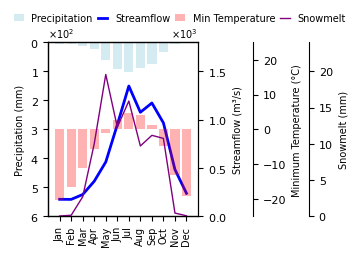

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


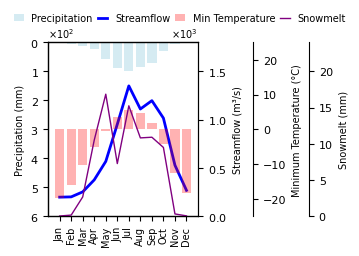

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


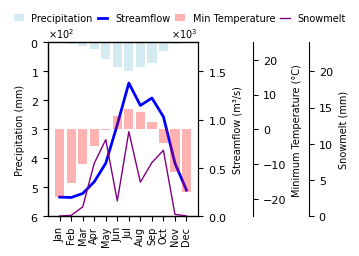

In [59]:
start = '1972-01-01'
end = '2019-12-31'

for hydro_station in hydro_stations:
    station_names = hydrostation_metestations[hydro_station]
    index = pd.date_range(start,end,freq='MS')
    # Initialize DataFrames to store aggregated data
    pcp_data = pd.DataFrame()
    maxtmp_data = pd.DataFrame()
    mintmp_data = pd.DataFrame()
    slr_data = pd.DataFrame()
    hmd_data = pd.DataFrame()
    wnd_data = pd.DataFrame()
    total_area = sum(metestation_controal_area_dict[station] for station in station_names)
    weights = {station: metestation_controal_area_dict[station] / total_area for station in station_names}
    for station in station_names:
        # Read climate data for each station
        station_data = pd.read_csv(f'D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{station}.csv', 
                                   index_col=['DATE'], parse_dates=['DATE'])
        station_calval = station_data.loc[start:end]
        # Aggregate data
        pcp_data[station] = station_calval['P2020(mm)'].resample('MS').sum() * weights[station]
        maxtmp_data[station] = station_calval['MAX-TEM(C)'].resample('MS').mean() * weights[station]
        mintmp_data[station] = station_calval['MIN-TEM(C)'].resample('MS').mean() * weights[station]
        slr_data[station] = station_calval['SLR(MJ/m^2)'].resample('MS').sum() * weights[station]
        hmd_data[station] = station_calval['AVG-RHU(%)'].resample('MS').mean() * weights[station]
        wnd_data[station] = station_calval['AVG-WV(m/s)'].resample('MS').mean() * weights[station]

    # Calculate weighted averages across stations
    pcp_avg = pcp_data.sum(axis=1)
    pcp_avg.name = 'P2020(mm)'
    pcp_avg.index = index
    maxtmp_avg = maxtmp_data.sum(axis=1)
    maxtmp_avg.name = 'MAX-TEM(C)'
    maxtmp_avg.index = index
    mintmp_avg = mintmp_data.sum(axis=1)
    mintmp_avg.name = 'MIN-TEM(C)'
    mintmp_avg.index = index
    slr_avg = slr_data.sum(axis=1)
    slr_avg.name = 'SLR(MJ/m^2)'
    slr_avg.index = index
    hmd_avg = hmd_data.sum(axis=1)
    hmd_avg.name = 'AVG-RHU(%)'
    hmd_avg.index = index
    wnd_avg = wnd_data.sum(axis=1)
    wnd_avg.name = 'AVG-WV(m/s)'
    wnd_avg.index = index

    # Read water balance data
    wb = pd.read_csv(f'../result/SWATPlusCalValSimData/YellowRiver{hydrostation_abbrs[hydro_station]}_BasinWaterBalance_1972_2019.csv', 
                     index_col=['date'], parse_dates=['date'])
    wb = wb.loc[start:end]
    wb = wb.drop(columns=['mon', 'day', 'yr', 'name'])
    wb = wb.sort_index()
    wb.index = index

    # Read monthly streamflow data
    flow = pd.read_csv(f'../data/{hydro_station}_natural_monthly_flow.csv', 
                       index_col=['date'], parse_dates=['date'])
    flow = flow.loc[start:end]
    flow = flow.sort_index()
    flow.index = index

    # Calculate mean monthly precipitation, streamflow, maximum temperature and snowmelt
    monthly_pcp = pcp_avg.groupby(pcp_avg.index.month).mean()
    monthly_flow = flow.groupby(flow.index.month).mean()
    monthly_mintemp = mintmp_avg.groupby(mintmp_avg.index.month).mean()
    monthly_snomlt = wb['snomlt(mm)'].groupby(wb.index.month).mean()
    monthly_wb_pcp = wb['precip(mm)'].groupby(wb.index.month).mean()

    # Create figure with three y-axes
    fontsize = 7
    fig, ax1 = plt.subplots(figsize=(3.48, 2.48))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()
    
    # Offset the right spine of ax3 and ax4 for clarity
    ax3.spines['right'].set_position(('outward', 40))
    ax4.spines['right'].set_position(('outward', 80))

    # Plot precipitation as inverted bars
    precip_bars = ax1.bar(range(1,13), monthly_pcp.values, color='lightblue', alpha=0.5, label='Precipitation')
    ax1.set_ylim(600, 0)  # Invert y-axis with increased range
    ax1.set_ylabel('Precipitation (mm)', fontsize=fontsize)
    # Set scientific notation for precipitation axis with font size 8
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.yaxis.get_offset_text().set_fontsize(fontsize)

    # Plot streamflow as line
    flow_line = ax2.plot(range(1,13), monthly_flow.values, color='blue', linewidth=2, label='Streamflow')[0]
    ax2.set_ylabel('Streamflow (m³/s)', fontsize=fontsize)
    ax2.set_ylim(0,1800)
    # Set scientific notation for streamflow axis with font size 8
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.yaxis.get_offset_text().set_fontsize(fontsize)

    # Plot minimum temperature as bars
    temp_bars = ax3.bar(range(1,13), monthly_mintemp.values, color='red', alpha=0.3, label='Min Temperature')
    ax3.set_ylabel('Minimum Temperature (°C)', fontsize=fontsize)
    ax3.set_ylim(-25,25)

    # Plot snowmelt as line
    snomlt_line = ax4.plot(range(1,13), monthly_snomlt.values, color='purple', linewidth=1, linestyle='-', label='Snowmelt')[0]
    ax4.set_ylabel('Snowmelt (mm)', fontsize=fontsize)
    ax4.set_ylim(0, 24)

    # Add legend at top with 4 columns
    ax1.legend([precip_bars, flow_line, temp_bars, snomlt_line], 
               ['Precipitation', 'Streamflow', 'Min Temperature', 'Snowmelt'],
               loc='upper center', bbox_to_anchor=(0.88, 1.22),
               ncol=4, fontsize=fontsize, frameon=False,handlelength=1,columnspacing=0.5)

    # Set x-axis labels with 90 degree rotation
    ax1.set_xticks(range(1,13))
    ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
                        fontsize=fontsize, rotation=90)
    plt.subplots_adjust(left=0.12,right=0.55,bottom=0.15,top=0.85)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}.png',format='png',dpi=300)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}.eps',format='eps',dpi=1000)
    plt.savefig(f'../figs/AvgPrecpMinTemVersusFlow_{hydro_station}.tif', format='TIFF', dpi=500)
    plt.show()